Using device: cpu
Loading data...
Loaded 568 images from NN_Combined_MRI_Dataset/test/
Loading model...


/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_2866/3606513690.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

Model loaded from Combined_MRI_Dataset/model_output/best_model.pt
Evaluating model...


Evaluating: 100%|███████████████████████████████| 18/18 [00:02<00:00,  7.33it/s]


Classes present in test data: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

Test Accuracy: 0.9806

Confusion Matrix:
[[ 87   0   0   2]
 [  0   4   0   0]
 [  0   0 250   2]
 [  3   0   4 216]]

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9667    0.9775    0.9721        89
 Moderate_Demented     1.0000    1.0000    1.0000         4
      Non_Demented     0.9843    0.9921    0.9881       252
Very_Mild_Demented     0.9818    0.9686    0.9752       223

          accuracy                         0.9806       568
         macro avg     0.9832    0.9846    0.9838       568
      weighted avg     0.9807    0.9806    0.9806       568

Generating confusion matrix visualization...
Confusion matrix saved to Combined_MRI_Dataset/model_output/confusion_matrix.png


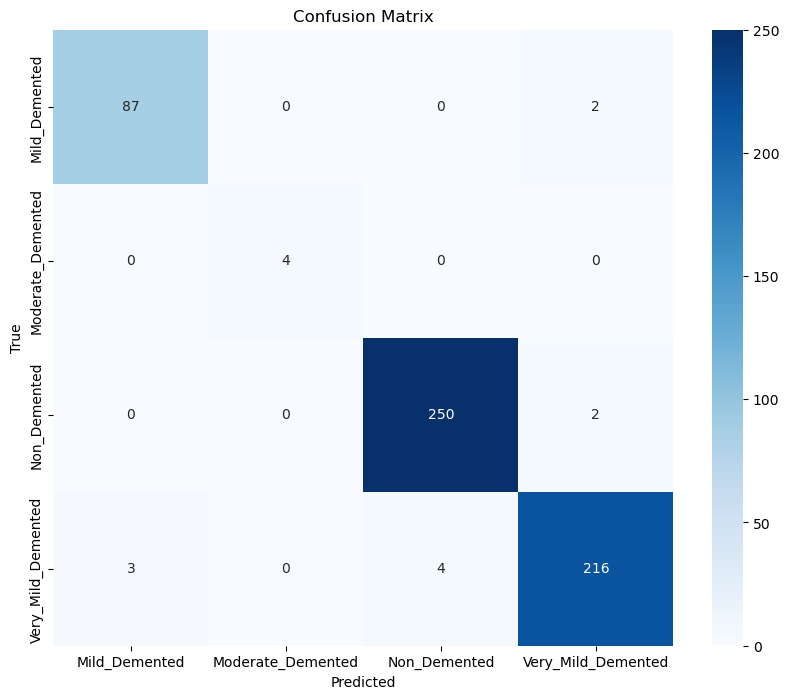

Saved all results to: Combined_MRI_Dataset/model_output/


In [2]:
import os
# cv2 import removed (not needed without Grad-CAM)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# Constants
N_CLASSES = 4
CLASS_NAMES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
test_data_dir = "NN_Combined_MRI_Dataset/test/"
model_dir = "Combined_MRI_Dataset/model_output/"
output_dir = model_dir  # Use the same directory for output

class VentricleDataset(Dataset):
    def __init__(self, data_dir):
        # Only use the test directory or direct path
        if os.path.exists(os.path.join(data_dir, 'test')):
            self.data_dir = os.path.join(data_dir, 'test')
        else:
            # Allow direct path
            self.data_dir = data_dir
            
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = os.path.join(self.data_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory {class_dir} not found.")
                continue
                
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith('mask.png'):
                    # Only include mask files
                    self.images.append(os.path.join(class_dir, img_file))
                    self.labels.append(class_idx)
        
        print(f"Loaded {len(self.images)} images from {self.data_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(IMG_SIZE)  # Ensure consistent size
        
        # Normalize to [0,1]
        tensor = TF.to_tensor(img)
        
        return tensor, torch.tensor(self.labels[idx], dtype=torch.long)

class VentricleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Two convolutional blocks
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        # Calculate flattened size after 2 pooling layers (4x reduction)
        self.fc_input_size = 128 * (IMG_SIZE[0]//4) * (IMG_SIZE[1]//4)
        
        # Classifier - fixed the input size based on calculated dimensions
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(128, N_CLASSES)
    
    def forward(self, x):
        x = self.batchnorm1(self.pool1(F.relu(self.conv1(x))))
        x = self.batchnorm2(self.pool2(F.relu(self.conv2(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        return self.out(x)

def load_model(model_path):
    """Load a trained model from disk"""
    model = VentricleCNN()
    
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Model loaded from {model_path}")
    else:
        print(f"Warning: Model file {model_path} not found. Using untrained model.")
    
    return model

def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Find unique classes in the test data
    unique_labels = np.unique(all_labels)
    present_classes = [CLASS_NAMES[i] for i in unique_labels]
    print(f"Classes present in test data: {present_classes}")
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                 target_names=present_classes, 
                                 digits=4,
                                 labels=unique_labels)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    
    return accuracy, cm, report, present_classes

def plot_confusion_matrix(cm, class_names, save_path=None):
    """Plot and optionally save a confusion matrix visualization"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()

# Grad-CAM visualization function removed as requested

def main():
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    print("Loading data...")
    # Load test data from specified path
    test_set = VentricleDataset(test_data_dir)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Loading model...")
    model_path = os.path.join(model_dir, "best_model.pt")
    model = load_model(model_path)
    model.to(device)
    
    print("Evaluating model...")
    accuracy, cm, report, present_classes = evaluate_model(model, test_loader, device)
    
    print("Generating confusion matrix visualization...")
    cm_save_path = os.path.join(output_dir, "confusion_matrix.png")
    plot_confusion_matrix(cm, present_classes, cm_save_path)
    
    # Save report to file
    report_path = os.path.join(output_dir, "classification_report.txt")
    with open(report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
        f.write("Confusion Matrix:\n")
        f.write(str(cm))
        f.write("\n\nClassification Report:\n")
        f.write(report)
    
    print("Saved all results to:", output_dir)

if __name__ == "__main__":
    main()